## Loading DEA data

#### In this tutorial we look at the different ways of loading data and constructing queries for the DEA collections.
#### Let's start by loading the libraries and creating the Datacube object to work with DEA:

In [2]:
import datacube
from check_answer import check_answer
from odc.ui import with_ui_cbk

dc = datacube.Datacube(app="loading_data")

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


#### As we have previously seen, the `dc.load()` function returns a XArray Dataset object containing the results of our query. This query should specify the collection, temporal and spatial extents that we want.

#### The `dc.load()` function requires the following minimum arguments:

* `product`: The data product to load (from `list_products()` function).
* `x`: The spatial region in the *x* dimension. By default, the *x* and *y* arguments accept queries in a geographical co-ordinate system WGS84, identified by the EPSG code *4326*.
* `y`: The spatial region in the *y* dimension. The dimensions ``longitude``/``latitude`` and ``x``/``y`` can be used interchangeably.
* `time`: The temporal extent. The time dimension can be specified using a tuple of datetime objects or strings in the "YYYY", "YYYY-MM" or "YYYY-MM-DD" format. 

#### For example, to load 2015 data from the [Landsat 8 NBAR-T annual geomedian product](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual) for Moreton Bay in southern Queensland, use the following parameters:

* `product`: `ls8_nbart_geomedian_annual`
* `x`: `(153.3, 153.4)`
* `y`: `(-27.5, -27.6)`
* `time`: `("2015-01-01", "2015-12-31")`

#### Run the following cell to load all datasets from the `ls8_nbart_geomedian_annual` product that match this spatial and temporal extent:

In [3]:
ds = dc.load(product="ls8_nbart_geomedian_annual",
             x=(153.3, 153.4),
             y=(-27.5, -27.6),
             time=("2015-01-01", "2015-12-31"))

ds

<xarray.Dataset>
Dimensions:      (time: 1, x: 461, y: 508)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01
  * y            (y) float64 -3.156e+06 -3.156e+06 ... -3.168e+06 -3.168e+06
  * x            (x) float64 2.067e+06 2.067e+06 ... 2.079e+06 2.079e+06
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) int16 491 490 489 493 499 ... 372 313 289 286 294
    green        (time, y, x) int16 534 538 538 543 548 ... 545 483 421 394 399
    red          (time, y, x) int16 248 252 252 253 257 ... 457 364 347 362 350
    nir          (time, y, x) int16 108 106 105 105 108 ... 2522 2292 2351 2399
    swir1        (time, y, x) int16 64 65 62 62 64 ... 1616 1261 1057 1070 1101
    swir2        (time, y, x) int16 53 53 51 51 54 51 ... 886 627 510 503 512
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

#### The variable `ds` has returned an `xarray.Dataset` containing all data that matched the spatial and temporal query parameters inputted into `dc.load`.

*Dimensions* 

* This header identifies the number of timesteps returned in the search (`time: 1`) as well as the number of pixels in the `x` and `y` directions of the data query.

*Coordinates* 

* `time` identifies the date attributed to each returned timestep.
* `x` and `y` are the coordinates for each pixel within the spatial bounds of the query.

*Data variables*

* These are the measurements available for the nominated product. 
For every date (`time`) returned by the query, the measured value at each pixel (`y`, `x`) is returned as an array for each measurement.
Each data variable is itself an `xarray.DataArray` object.

*Attributes*

* `crs` identifies the coordinate reference system (CRS) of the loaded data. 

>Note: Although we have specified the spatial extents in our query using geographical coordinates in degrees, the returned object specifies a EPSG:3577 CRS.

#### Exercise 2.1: Data variable `blue` specifies dimensions (time, y, x). Can you guess the dimensions of the array containing these data by looking at the description

In [4]:
ds.blue.shape

(1, 508, 461)

In [5]:
#Fill the following list with the size of each dimension
answ = [1, 508, 461]

check_answer("DEA2.1", answ)

'Well done!'

#### Remember that Datasets include DataArrays to represent individual variables. For example, to access variable `nir` we can do:

In [ ]:
ds.nir

#### Exercise 2.2: If you remember from the XArray tutorial, variables in a Dataset are called DataArrays. DataArrays use numpy arrays as the underlying storage option. Can you access get the `blue` variable and assign its underlying numpy array to the `answ` variable?

In [ ]:
answ = ds.?

check_answer("DEA2.2", str(type(answ)))

#### Exercise 2.3: Looking at the attributes of the previous DataArray, can you determine what value is used to determine no data values?

In [ ]:
answ = ?

check_answer("DEA2.3", answ)

#### The `dc.load()` function can be extended to define the output Dataset by including extra options:

* `measurements:` This argument is used to provide a list of measurement names to load, as listed in `dc.list_measurements()`. 
For satellite datasets, measurements contain data for each individual satellite band (e.g. near infrared). 
If not provided, all measurements for the product will be returned.
* `crs:` The coordinate reference system (CRS) of the query's `x` and `y` coordinates is assumed to be `WGS84`/`EPSG:4326` unless the `crs` field is supplied, even if the stored data is in another projection or the `output_crs` is specified. 
The `crs` parameter is required if the query's coordinates are in any other CRS.
* `group_by:` Satellite datasets based around scenes can have multiple observations per day with slightly different time stamps as the satellite collects data along its path.
These observations can be combined by reducing the `time` dimension to the day level using `group_by=solar_day`.
* `output_crs` and `resolution`: To reproject or change the resolution the data, supply the `output_crs` and `resolution` fields.    
* `resampling`: This argument allows you to specify a custom spatial resampling method to use when data is reprojected into a different CRS. 

> Note: For help with customisation options, run `help(dc.load)` in an empty cell or visit the function's [documentation page](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html)

#### For example, to load the `red`, `green` and `blue` satellite bands only, we can add `measurements=["red", "green", "blue"]` to the query:

In [6]:
ds_rgb = dc.load(product="ls8_nbart_geomedian_annual",
                 measurements=["red", "green", "blue"],
                 x=(153.3, 153.4),
                 y=(-27.5, -27.6),
                 time=("2015-01-01", "2015-12-31"))

ds_rgb

<xarray.Dataset>
Dimensions:      (time: 1, x: 461, y: 508)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01
  * y            (y) float64 -3.156e+06 -3.156e+06 ... -3.168e+06 -3.168e+06
  * x            (x) float64 2.067e+06 2.067e+06 ... 2.079e+06 2.079e+06
    spatial_ref  int32 3577
Data variables:
    red          (time, y, x) int16 248 252 252 253 257 ... 457 364 347 362 350
    green        (time, y, x) int16 534 538 538 543 548 ... 545 483 421 394 399
    blue         (time, y, x) int16 491 490 489 493 499 ... 372 313 289 286 294
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

> Note: **Data variables** component of the `xarray.Dataset` now includes only the measurements specified in the query (i.e. the `red`, `green` and `blue` satellite bands).

#### The previous example passes the parameters of the `load` function explicitly. Another way, sometimes more convenient is to pack all the parameters into a dictionary and then pass it to the function using the Python `**kwargs` or "keyword argument unpacking" operator.

#### Exercise 2.4: Can you pack the parameters in the previous example into a dictionary?

In [8]:
answ = {"product":"ls8_nbart_geomedian_annual",
                 "measurements":["red", "green", "blue"],
                 "x":(153.3, 153.4),
                 "y":(-27.5, -27.6),
                 "time":("2015-01-01", "2015-12-31")}

check_answer("DEA2.4", answ['measurements'])

'Well done!'

In [10]:
ds_rgb = dc.load(**answ)

ds_rgb

<xarray.Dataset>
Dimensions:      (time: 1, x: 461, y: 508)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01
  * y            (y) float64 -3.156e+06 -3.156e+06 ... -3.168e+06 -3.168e+06
  * x            (x) float64 2.067e+06 2.067e+06 ... 2.079e+06 2.079e+06
    spatial_ref  int32 3577
Data variables:
    red          (time, y, x) int16 248 252 252 253 257 ... 457 364 347 362 350
    green        (time, y, x) int16 534 538 538 543 548 ... 545 483 421 394 399
    blue         (time, y, x) int16 491 490 489 493 499 ... 372 313 289 286 294
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

#### Exercise 2.5: Use the previous dictionary to pass it to the `dc.load()` function using the `**query` option.

#### By default, `dc.load()` assumes that the queried `x` and `y` coordinates are in the `WGS84`/`EPSG:4326` CRS. If these coordinates are in a different coordinate system, specify this using the `crs` parameter.

#### By default the returned object uses the Australian Albers (`EPSG:3577`) so there is no need to include in the query object `crs="EPSG:3577"`. Certain applications may require that data is output into a specific CRS. Data can be reprojected by specifying the new `output_crs` and identifying the `resolution` required.

#### This example reprojects data to a new CRS (UTM Zone 56S, `EPSG:32756`) and resolution (250 x 250 m). 

>Note: Most CRSs define a negative value for the first dimension, which corresponds to the north-south to denote decreasing values as moving to the south (e.g. `(-250, 250)`):

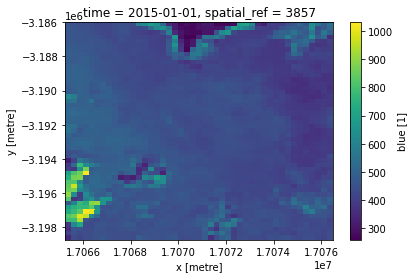

In [15]:
ds_reprojected = dc.load(product="ls8_nbart_geomedian_annual",
                         x=(153.3, 153.4),
                         y=(-27.5, -27.6),
                         time=("2015-01-01", "2015-12-31"),
                         output_crs="EPSG:3857",
                         resolution=(-250, 250))

ds_reprojected.blue.isel(time=0).plot()

Note that the `crs` attribute in the **Attributes** section has changed to `EPSG:32756`. 
Due to the larger 250 m resolution, there are now fewer pixels on the `x` and `y` dimensions (e.g. `x: 40, y: 45` compared to `x: 461, y: 508` in earlier examples).

#### Exercise 2.6: Can you plot a true colour RGB image of the previous Dataset?

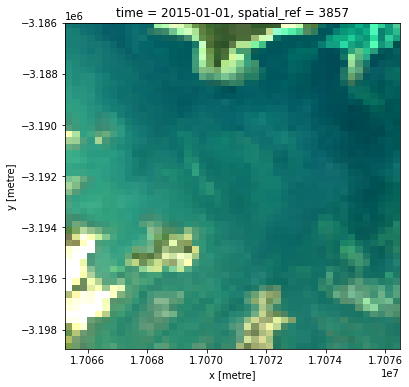

In [17]:
ds_reprojected[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(robust=True, figsize=(6,6))

#### When a product is re-projected to a different CRS and/or resolution, the new pixel grid may differ from the original input pixels by size, number and alignment. It is therefore necessary to apply a spatial "resampling" rule that allocates input pixel values into the new pixel grid.

#### By default, `dc.load()` resamples pixel values using "nearest neighbour" resampling, which allocates each new pixel with the value of the closest input pixel. Depending on the type of data and the analysis being run, this may not be the most appropriate choice (e.g. for continuous data).

#### The `resampling` parameter in `dc.load()` allows you to choose a custom resampling method from the following options: 

```
"nearest", "cubic", "bilinear", "cubic_spline", "lanczos", 
"average", "mode", "gauss", "max", "min", "med", "q1", "q3"
```

#### This example loads resampled data using the "average" resampling method:

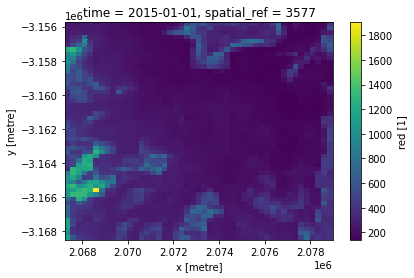

In [24]:
# Note the additional `resampling` parameter
ds_averageresampling = dc.load(product="ls8_nbart_geomedian_annual",
                               x=(153.3, 153.4),
                               y=(-27.5, -27.6),
                               time=("2015-01-01", "2015-12-31"),
                               resolution=(-250, 250),
                               resampling="max")


ds_averageresampling.red.isel(time=0).plot()

#### When loading large amounts of data, it can be useful to view the progress of the data load. The `progress_cbk` parameter in `dc.load()` adds a progress bar that indicates how the load is progressing.

#### The example cell below loads 5 years of data (2013, 2014, 2015, 2016 and 2017) from the `ls8_nbart_geomedian_annual` product with a progress bar:

>Note: In this example we are using a dictionary to define the query parameters and passing this to the `load` function using the `**kwargs` mode.

In [26]:
query = {"x": (153.3, 153.4),
         "y": (-27.5, -27.6),
         "time": ("2013", "2017")}

ds_progress = dc.load(product="ls8_nbart_geomedian_annual",
                      progress_cbk=with_ui_cbk(),
                      **query)

ds_progress

<xarray.Dataset>
Dimensions:      (time: 5, x: 461, y: 508)
Coordinates:
  * time         (time) datetime64[ns] 2013-01-01 2014-01-01 ... 2017-01-01
  * y            (y) float64 -3.156e+06 -3.156e+06 ... -3.168e+06 -3.168e+06
  * x            (x) float64 2.067e+06 2.067e+06 ... 2.079e+06 2.079e+06
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) int16 516 517 523 514 506 ... 360 331 310 300 314
    green        (time, y, x) int16 552 554 565 553 542 ... 531 472 408 389 416
    red          (time, y, x) int16 268 273 282 272 265 ... 420 363 344 348 355
    nir          (time, y, x) int16 108 112 116 106 105 ... 2615 2446 2494 2644
    swir1        (time, y, x) int16 63 63 68 60 61 ... 1510 1163 964 1004 1127
    swir2        (time, y, x) int16 51 50 53 49 49 50 ... 730 541 453 449 499
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

#### Exercise 2.7: Can you display an NDVI index for the image corresponding to year 2015 in the previous Dataset?

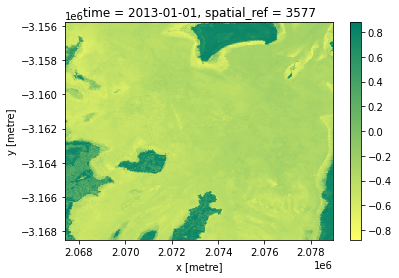

In [29]:
ndvi = (ds_progress.nir-ds_progress.red)/(ds_progress.red+ds_progress.nir)

ndvi.isel(time=0).plot(cmap="summer_r")

#### Disclaimer: The original notebook for this tutorial has been taken from the Sandbox `Beginners_guide` folder. Refer to the conditions specified in the original notebook and for updated versions of the code.

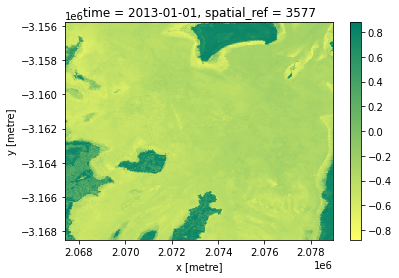

In [32]:
def calc_ndvi(ds): 
    return (ds.nir - ds.red) / (ds.red + ds.nir) 

calc_ndvi(ds_progress).isel(time=0).plot(cmap="summer_r")